In [ ]:
# 同原始GAN
#  生成器，与判别器改为使用CNN网络

In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Image
import cv2
import PIL
import json, os

In [ ]:
# 定义全局变量
img_shape = (28, 28, 1)
batch_size = 200
latent_dim = 100
sample_interval=1
epochs=10

In [ ]:
# 定义生成器
def build_generator():

        input=keras.Input(shape=latent_dim)

        x=layers.Dense(256*7*7)(input)
        x=layers.BatchNormalization(momentum=0.8)(x)
        x=layers.Activation(activation='relu')(x)
        x=layers.Reshape((7,7,256))(x)

        x=layers.UpSampling2D((2,2))(x)
        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.Activation(activation='relu')(x)

        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.Activation(activation='relu')(x)

        x = layers.Conv2D(32, (3, 3), padding='same')(x)
        x = layers.Conv2D(32, (3, 3), padding='same')(x)
        x = layers.BatchNormalization(momentum=0.8)(x)
        x = layers.Activation(activation='relu')(x)

        output = layers.Conv2D(1, (3, 3), padding='same',activation='sigmoid')(x)

        model=keras.Model(inputs=input,outputs=output,name='generator')
        model.summary()
        return model

In [ ]:
def build_discriminator():#判别器
        input=keras.Input(shape=img_shape)
        x = layers.Conv2D(32, (3, 3), padding='same')(input)
        x = layers.Conv2D(32, (3, 3), padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)
        x = layers.MaxPooling2D(2,2)(x)

        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)
        x = layers.MaxPooling2D(2, 2)(x)

        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)
        x = layers.MaxPooling2D(2, 2)(x)

        x = layers.Conv2D(256, (3, 3), padding='same')(x)
        x = layers.Conv2D(256, (3, 3), padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)

        x=layers.Flatten()(x)
        output=layers.Dense(1,activation='sigmoid')(x)

        model=keras.Model(inputs=input,outputs=output,name='discriminator')
        model.summary()
        return model

In [ ]:
generator_model = build_generator()
discriminator_model = build_discriminator()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_4 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_4 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 128)       29

In [ ]:
# 建立GAN模型
def bulid_model():
      discriminator_model.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(0.0001, 0.000001),
                    metrics=['accuracy'])
      
      #使判别器不训练，固定判别器
      discriminator_model.trainable = False
      inputs = keras.Input(shape=latent_dim)
      img = generator_model(inputs)
      outputs = discriminator_model(img)
      model = keras.Model(inputs=inputs, outputs=outputs)
      model.summary()
      # 训练GAN
      model.compile(optimizer=keras.optimizers.Adam(0.0001, 0.000001),
                    loss='binary_crossentropy',
                    )
      return model

In [ ]:
# 模型实例化
model =bulid_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Functional)       (None, 28, 28, 1)         1899361   
_________________________________________________________________
discriminator (Functional)   (None, 1)                 1173985   
Total params: 3,073,346
Trainable params: 1,873,825
Non-trainable params: 1,199,521
_________________________________________________________________


In [ ]:
# 数据加载
def load_data():
        (train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
        train_images = train_images /255
        train_images = np.expand_dims(train_images, axis=3)
        print('img_number:',train_images.shape)
        return train_images
 #生成图片
def generate_sample_images(epoch):  

      row, col = 5, 5#
      noise = np.random.normal(0, 1, (row * col, 100))
      #生成噪声
      gan_imgs = generator_model.predict(noise)
      fig, axs = plt.subplots(row, col)
      #生成5*5的画板
      idx = 0
      for i in range(row):
          for j in range(col):
              axs[i, j].imshow(gan_imgs[idx, :, :, 0], cmap='gray')
              axs[i, j].axis('off')
              idx += 1
      plt.show()

In [ ]:
# 定义训练
def train():
    train_images=load_data()

    #生成标签
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    step=int(train_images.shape[0]/batch_size)
    #计算步长
    print('step:',step)

    for epoch in range(epochs):
        print(epoch)
        train_images = (tf.random.shuffle(train_images)).numpy()
        #每个epoch打乱一次
        if epoch % 2 == 0:
          # 图片展示
            generate_sample_images(epoch)

        for i in range(step):

            idx = np.arange(i*batch_size,i*batch_size+batch_size,1)
            #生成索引
            imgs =train_images[idx]
            #读取索引对应的图片
            noise = np.random.normal(0, 1, (batch_size, 100))
            gan_imgs = generator_model.predict(noise)
            #通过噪声生成图片
            #训练判别器
            discriminator_loss_real = discriminator_model.train_on_batch(imgs, valid)  # 真实数据对应标签1
            discriminator_loss_fake = discriminator_model.train_on_batch(gan_imgs, fake)  # 生成的数据对应标签0
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
            #训练生成器
            noise = np.random.normal(0, 1, (batch_size, 100))
            # noise = np.random.normal(0, 1, (1000, 100))
            # 判别器训练一回，生成器生成5回
            # for j in range(5):
            #   a=j*200
            #   b=(j+1)*200
            #   noise_temp=noise[a:b]
            generator_loss = model.train_on_batch(noise, valid)
            if i%100==0:#每100步进行输出
                print("epoch:%d step:%d [discriminator_loss: %f, acc: %.2f%%] [generator_loss: %f]" % (
                    epoch,i,discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))


img_number: (60000, 28, 28, 1)
step: 300
0


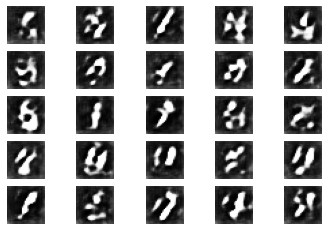

epoch:0 step:0 [discriminator_loss: 0.686799, acc: 49.25%] [generator_loss: 0.717094]
epoch:0 step:100 [discriminator_loss: 0.488994, acc: 78.00%] [generator_loss: 2.385789]
epoch:0 step:200 [discriminator_loss: 0.671490, acc: 57.25%] [generator_loss: 1.069866]
1
epoch:1 step:0 [discriminator_loss: 0.684170, acc: 55.00%] [generator_loss: 0.862875]
epoch:1 step:100 [discriminator_loss: 0.689809, acc: 50.75%] [generator_loss: 0.832214]
epoch:1 step:200 [discriminator_loss: 0.680106, acc: 58.50%] [generator_loss: 0.805226]
2


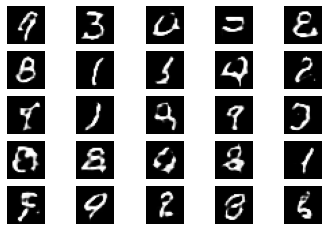

epoch:2 step:0 [discriminator_loss: 0.668721, acc: 63.25%] [generator_loss: 0.823960]
epoch:2 step:100 [discriminator_loss: 0.680783, acc: 55.25%] [generator_loss: 0.829456]
epoch:2 step:200 [discriminator_loss: 0.672865, acc: 59.00%] [generator_loss: 0.825836]
3
epoch:3 step:0 [discriminator_loss: 0.640733, acc: 63.25%] [generator_loss: 0.906384]
epoch:3 step:100 [discriminator_loss: 0.658660, acc: 57.00%] [generator_loss: 0.879481]
epoch:3 step:200 [discriminator_loss: 0.635054, acc: 62.75%] [generator_loss: 0.930342]
4


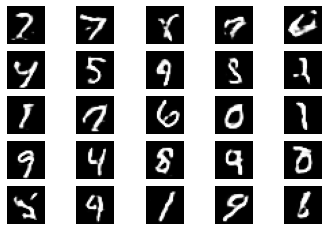

epoch:4 step:0 [discriminator_loss: 0.643901, acc: 62.75%] [generator_loss: 0.902657]
epoch:4 step:100 [discriminator_loss: 0.628503, acc: 63.00%] [generator_loss: 0.956084]
epoch:4 step:200 [discriminator_loss: 0.622460, acc: 65.25%] [generator_loss: 1.016035]
5
epoch:5 step:0 [discriminator_loss: 0.665893, acc: 60.75%] [generator_loss: 0.991473]
epoch:5 step:100 [discriminator_loss: 0.632177, acc: 63.75%] [generator_loss: 1.019901]
epoch:5 step:200 [discriminator_loss: 0.622525, acc: 66.00%] [generator_loss: 0.973664]


In [ ]:
if __name__ == '__main__':
   train()